# Thin beam

In [5]:
# import API
import pwpp
from pwpp import *
import pickle
filename='Thin'

In [6]:
# load
infile = open(filename,'rb')
ath_y,ath_x,adist_y,adist_x,da,az,a0,Deltalst,Np_th,Np_smpl = pickle.load(infile)
infile.close()

In [7]:
## parameters
# laser
I21 = 5; #[]
lbd = 0.8; #[\mu m]
a0 = 0.855*sqrt(1e3*I21)*lbd; #[]
tau = 35; #[fs]
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
W0 = 3; #[\mu m]
zR = pi*W0**2/lbd; #[\mu m]
n = tau*c/(lbd*1e-6)*1e-15; #[]
# beam
E0 = 13; #[GeV]
g0 = E0/m; #[]
Qb = 1 * 1e-12; #[C]
Nb = Qb/e; #[]
L = 200.0; #[\mu m]
R = 0.5; #[\mu m]
sigmaR = R/sqrt(2); #[\mu m]
# limit
az = a0/sqrt(1+(L/4/zR)**2)

# Interpolate N+
amin = 2
a0int = np.linspace(amin,a0,300);
Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int])
Npinterp1d = interpolate.interp1d(a0int, Npint)

def dNda(a,Delta):
    """theory"""
    zm = -L/4+Delta
    zp = +L/4+Delta
    azm = a0/sqrt(1+(zm/zR)**2)
    azp = a0/sqrt(1+(zp/zR)**2)
    return np.sign(-zm)*np.piecewise(a, [a > azm, a <= azm], [lambda a: 2*Nb*zR/L * a0**2/a**2 / sqrt(a0**2-a**2), lambda a: 0]) + \
        np.sign(zp)*np.piecewise(a, [a > azp, a <= azp], [lambda a: 2*Nb*zR/L * a0**2/a**2 / sqrt(a0**2-a**2), lambda a: 0])

# Distribution

In [8]:
# simulation parameters
Nsmpl = int(1e6);

# distribution
Delta = 0; #[\mu m]
zdist = L/2*rng.random(Nsmpl)-L/4 + Delta; #[\mu m]

# calculate a
adim = 100; #[]
nbins = 50;
alst = np.linspace(0.001*a0,0.999*a0,adim); #[]
abins = np.linspace(0.001*a0,0.999*a0,nbins); #[]
da = abins[1]-abins[0]; #[]
adist = gauss3D(zdist,0,0,a0,W0,lbd); #[]
# histogram
adist_y,adist_x = np.histogram(adist,abins) #[]
# normalize to Nb
adist_y, adist_x = adist_y*Nb/Nsmpl, arraycenter(adist_x)
# analytical distribution
ath_y,ath_x = dNda(alst,Delta), alst

# Displacement

In [17]:
Deltalst = np.linspace(0,L/2,13);
Np_th = np.zeros(len(Deltalst));

for i in trange(len(Deltalst)):
    Delta = Deltalst[i];

    # analytical (Delta>0)
    zm = -L/4+Delta
    zp = +L/4+Delta
    azm = a0/sqrt(1+(zm/zR)**2)
    azp = a0/sqrt(1+(zp/zR)**2)
    Np_th[i] = quad(lambda a: dNda(a,Delta) * Np(g0,a,w0,n), azp, 0.9999*a0)[0]

In [13]:
Nsmpl = int(1e5);
Deltalst = np.linspace(0,L/2,13);
Np_smpl = np.zeros(len(Deltalst));

for i in trange(len(Deltalst)):
    Delta = Deltalst[i];
    
    # sampling
    zdist = L/2*rng.random(Nsmpl)-L/4 + Delta; #[\mu m]
    adist = gauss3D(zdist,0,0,a0,W0,lbd); #[]
    adist2 = adist[adist > amin]
    dNp = np.array([Npinterp1d(a) for a in adist2 ])
    Np_smpl[i] = np.sum( dNp ) * Nb/Nsmpl

In [22]:
# save
outfile = open(filename,'wb')
pickle.dump([ath_y,ath_x,adist_y,adist_x,da,az,a0,Deltalst,Np_th,Np_smpl],outfile)
outfile.close()

In [ ]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3.3))

plt.subplot(121)
plt.style.use("style.txt")
plt.plot(ath_x, ath_y*da,'k--',label=r'Theory')
plt.plot(adist_x, adist_y,'.',label=r'Sampling')
plt.xlim([0.9*az,a0])
plt.ylim([0,max(adist_y)])
plt.yticks([0,2e5,4e5,6e5])
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{Q_b}{1\mathrm{pC}} \right]$',labelpad=15)
plt.legend(frameon=False,loc='upper left')
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
axes[0].set_aspect(aspect=4/3)

plt.subplot(122)
plt.plot(Deltalst, Np_th,'k--',label=r'Theory')
plt.plot(Deltalst, Np_smpl,'.',label=r'Sampling')
plt.xlabel(r'$\Delta_\parallel[\mu \textrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{Q_b}{1\mathrm{pC}} \right]$',labelpad=15)
plt.xlim([-2,102])
plt.ylim(0,6.5e6)
plt.yticks([0,2e6,4e6,6e6])
plt.legend(frameon=False)
#plt.title('Distribution')
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
axes[1].set_aspect(aspect=4/3)
plt.tight_layout()
#plt.savefig('3DL.pdf')
plt.show()

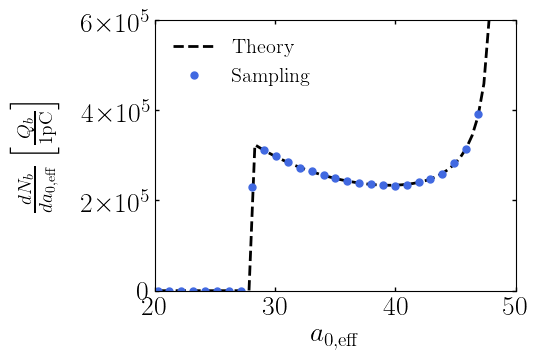

In [26]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(ath_x, ath_y*da,'k--',label=r'Theory')
plt.plot(adist_x, adist_y,'.',label=r'Sampling')
plt.xlabel(r'$a_{0,\mathrm{eff}}$')
plt.ylabel(r'$\frac{dN_b}{da_{0,\mathrm{eff}}} \left[ \frac{Q_b}{1\mathrm{pC}} \right]$',labelpad=15)
plt.legend(frameon=False,loc='upper left')
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.xlim([0.9*az,a0])
plt.ylim([0,6e5])
plt.xticks([20,30,40,50])
plt.yticks([0,2e5,4e5,6e5])
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('3DL_a.pdf')
plt.show()

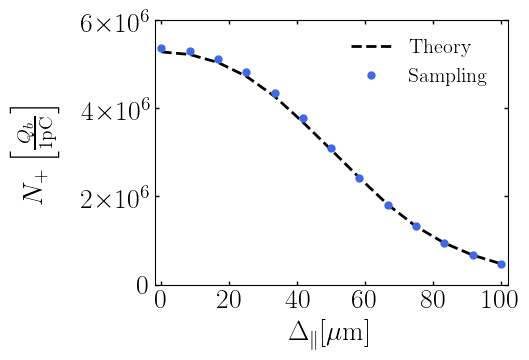

In [24]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

plt.plot(Deltalst, Np_th,'k--',label=r'Theory')
plt.plot(Deltalst, Np_smpl,'.',label=r'Sampling')
plt.xlabel(r'$\Delta_\parallel[\mu \textrm{m}]$')
plt.ylabel(r'$N_+ \left[ \frac{Q_b}{1\mathrm{pC}} \right]$',labelpad=15)
plt.legend(frameon=False)
plt.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True)
plt.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True)
plt.xlim([-2,102])
plt.ylim(0,6e6)
plt.xticks([0,20,40,60,80,100])
plt.yticks([0,2e6,4e6,6e6])
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('3DL_b.pdf')
plt.show()